# Grid Search to Find Good Solution for 0.8 Msun

In [626]:
# Imports
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from starmodel2 import starmodel
import matplotlib.colors as colors
%matplotlib inline

In [627]:
Msun = 1.989e33
Lsun = 3.826e33

In [628]:
 def gridsearch(pars,lumrange,teffrange,nlum=10,nteff=10,verbose=False):
    """
    Run a grid search of starmodel.
    
    Parameters
    ----------
    pars : list
       List with total stellar mass, X and Z.
    lumrange : list
       List with luminosity range to search, minimum and maximum.
    teffrange : list
       List with temperature range to search, minimum and maximum.
    nlum : int
       Number of luminosity points to search.  Default is 10.
    nteff : int
       Number of temperature points to search.  Default is 10.
    
    Returns
    -------
    data : dict
       Dictionary with all of the information
       
    Example
    -------
    
    data = gridsearch([1.0,0.70,0.08],[0.8,1.2],0.02,[5000.0,6000.0],50)
    
    """
    # pars should be [total mass, X, Z]
    totmass = pars[0]
    X = pars[1]
    Z = pars[2]
    """ Search a grid in Luminosity and Teff"""
    luminosity = np.linspace(lumrange[0],lumrange[1],nlum,endpoint=True)
    temperature = np.linspace(teffrange[0],teffrange[1],nteff,endpoint=True)
    print('Search grid is ',len(luminosity),' x ',len(temperature))
    igoof = np.zeros((len(luminosity),len(temperature)),int)
    mass0 = np.zeros((len(luminosity),len(temperature)),float)
    lum0 = np.zeros((len(luminosity),len(temperature)),float)
    temp0 = np.zeros((len(luminosity),len(temperature)),float)
    dtemp0 = np.zeros((len(luminosity),len(temperature)),float)
    drho0 = np.zeros((len(luminosity),len(temperature)),float)
    deps0 = np.zeros((len(luminosity),len(temperature)),float)
    # criteria:
    # 1: mass0 >0
    # 2: mass0 < 0.01*Mstar
    # 3: lum0 >0
    # 4: lum0 < 0.1*Lstar
    # 5: Tcore > Tshell2
    # 6: rhocore > rhoshell2
    # 7: epsiloncore > epsilonshell2
    criteria = np.zeros((len(luminosity),len(temperature),7),bool)
    for i,lum in enumerate(luminosity):
        for j,teff in enumerate(temperature):
            Igoof,ierr,istop,tab = starmodel(totmass,lum,teff,X,Z,verbose=False)
            igoof[i,j] = Igoof
            mass0[i,j] = tab['M'][-1]  # central shell
            lum0[i,j] = tab['L'][-1]   # central shell
            temp0[i,j] = tab['T'][-1]  # central shell
            dtemp0[i,j] = tab['T'][-1]-tab['T'][-2]
            drho0[i,j] = tab['rho'][-1]-tab['rho'][-2]
            deps0[i,j] = tab['epsilon'][-1]-tab['epsilon'][-2]
            criteria[i,j,0] = tab['M'][-1] > 0
            criteria[i,j,1] = tab['M'][-1] < 0.01*tab['M'][0]
            criteria[i,j,2] = tab['L'][-1] > 0
            criteria[i,j,3] = tab['L'][-1] < 0.1*tab['L'][0]
            criteria[i,j,4] = dtemp0[i,j] > 0
            criteria[i,j,5] = drho0[i,j] > 0
            criteria[i,j,6] = deps0[i,j] > 0

            if verbose:
                print(lum,teff,Igoof,mass0[i,j],lum0[i,j],temp0[i,j])
    
    data = {'pars':pars,'luminosity':luminosity,'temperature':temperature,'igoof':igoof,
            'mass0':mass0,'lum0':lum0,'temp0':temp0,'dtemp0':dtemp0,'drho0':drho0,
            'deps0':deps0,'criteria':criteria}
    return data

In [629]:
def analyzeresults(data):
    """ Analyze the grid results """
    
    pars = data['pars']
    luminosity = data['luminosity']
    temperature = data['temperature']
    mass0 = data['mass0']
    lum0 = data['lum0']
    temp0 = data['temp0']
        
    fig,axs = plt.subplots(5,1,figsize=(8,25))
        
    # Mass results
    print('Mass results')
    print('------------')
    print('Min M0=',np.min(mass0))
    print('Max M0=',np.max(mass0))
    print('Min |M0|=',np.min(np.abs(mass0)))
    bestind = np.unravel_index(np.argmin(np.abs(mass0), axis=None), mass0.shape)
    bestlum = luminosity[bestind[0]]
    bestteff = temperature[bestind[1]]
    print('Best index = ',bestind)
    print('Best Luminosity=',luminosity[bestind[0]])
    print('Best Temperature=',temperature[bestind[1]])
    print(' ')
    im1 = axs[0].imshow(mass0,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
    axs[0].scatter(temperature[bestind[1]],luminosity[bestind[0]],c='r',marker='+',s=200)
    plt.colorbar(im1, ax=axs[0])

    # Luminosity results
    print('Luminosity results')
    print('------------')
    print('Min M0=',np.min(lum0))
    print('Max M0=',np.max(lum0))
    print('Min |M0|=',np.min(np.abs(lum0)))
    bestind = np.unravel_index(np.argmin(np.abs(lum0), axis=None), mass0.shape)
    bestlum = luminosity[bestind[0]]
    bestteff = temperature[bestind[1]]
    print('Best index = ',bestind)
    print('Best Luminosity=',luminosity[bestind[0]])
    print('Best Temperature=',temperature[bestind[1]])
    print(' ')
    im1 = axs[1].imshow(lum0,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
    axs[1].scatter(temperature[bestind[1]],luminosity[bestind[0]],c='r',marker='+',s=200)
    plt.colorbar(im1, ax=axs[1])
    
    # Mass * Luminosity
    bestind = np.unravel_index(np.argmin(np.abs(mass0)/pars[0]*np.abs(lum0)/np.max(lum0), axis=None), mass0.shape)
    bestlum = luminosity[bestind[0]]
    bestteff = temperature[bestind[1]]
    print('Best index = ',bestind)
    print('Best Luminosity=',luminosity[bestind[0]])
    print('Best Temperature=',temperature[bestind[1]])
    im2 = axs[2].imshow(np.abs(mass0)*np.abs(lum0),extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
                   origin='lower',aspect='auto')
    axs[2].scatter(temperature[bestind[1]],luminosity[bestind[0]],c='r',marker='+',s=200)
    plt.colorbar(im1, ax=axs[2])
    
    
    Igoof,ierr,istop,tab = starmodel(pars[0],bestlum,bestteff,pars[1],pars[2],verbose=False)
    
    # Mass versus radius
    axs[3].plot(tab['r'],tab['M'])

    # Luminosity versus radius
    axs[4].plot(tab['r'],tab['L'])
    

In [630]:
def crossing(arr):
    """ Find points where the values cross from positive to negative or vice versa"""
    line1 = np.abs(np.gradient(np.sign(arr),axis=1)).astype(int)
    line2 = np.abs(np.gradient(np.sign(arr),axis=0)).astype(int)
    line = line1 | line2
    return line

In [631]:
#data = gridsearch([0.8,0.70,0.008],[0.2175,0.220],[3720,3730],nlum=70,nteff=70)
#data = gridsearch([0.8,0.70,0.008],[0.16,0.30],[3700,4300],nlum=120,nteff=120)
# 0.27155462,4212.18487
# 0.27155
# 0.271512605, 4214.234453
data = gridsearch([0.8,0.70,0.008],[0.2710,0.2720],[4210,4216],nlum=120,nteff=120)

Search grid is  120  x  120


Mass results
------------
Min M0= -5.06843406493936e+29
Max M0= 7.32892158757072e+29
Min |M0|= 1.101653967206677e+25
Best index =  (28, 50)
Best Luminosity= 0.2712352941176471
Best Temperature= 4212.5210084033615
 
Luminosity results
------------
Min M0= -5.059458866871249e+30
Max M0= 9.843103706189091e+30
Min |M0|= 6.746702177388149e+25
Best index =  (32, 76)
Best Luminosity= 0.27126890756302524
Best Temperature= 4213.83193277311
 
Best index =  (61, 84)
Best Luminosity= 0.27151260504201685
Best Temperature= 4214.235294117647


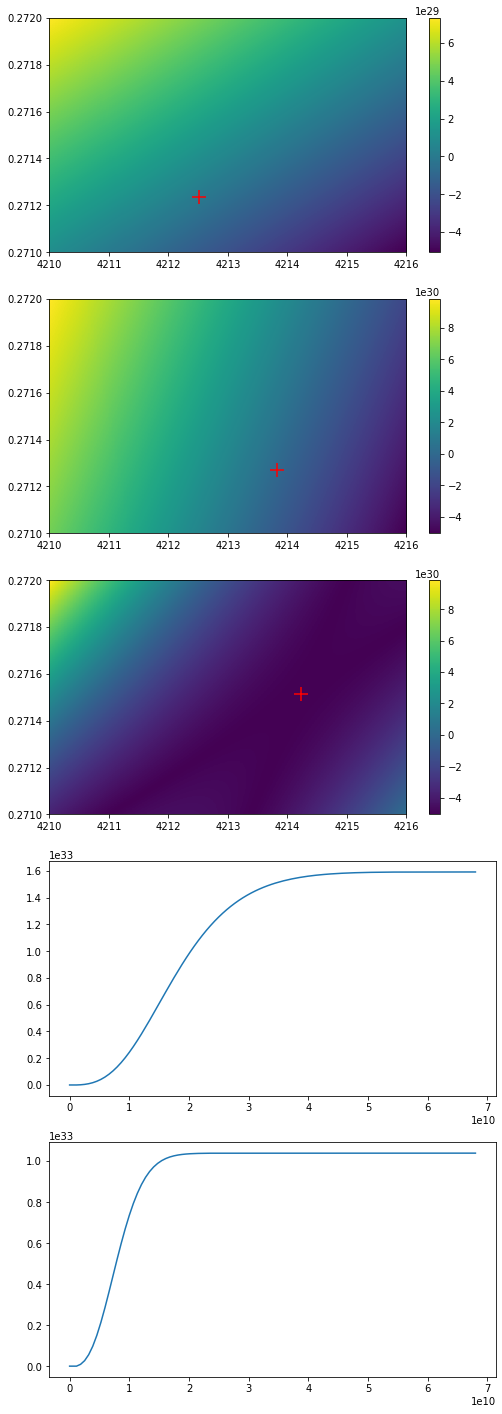

In [632]:
analyzeresults(data)

In [633]:
    pars = data['pars']
    luminosity = data['luminosity']
    temperature = data['temperature']
    mass0 = data['mass0']
    lum0 = data['lum0']
    temp0 = data['temp0']
    igoof = data['igoof']
    dtemp0 = data['dtemp0']
    drho0 = data['drho0']
    deps0 = data['deps0']
    criteria = data['criteria']

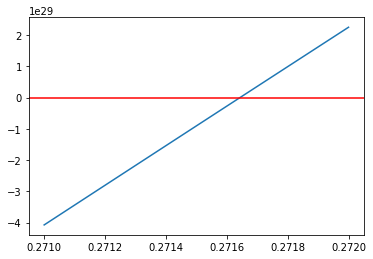

In [634]:
plt.plot(luminosity,mass0[:,100])
plt.axhline(0,0,1,c='r')

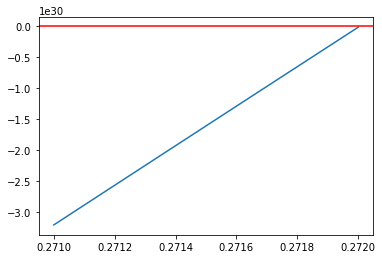

In [635]:
plt.plot(luminosity,lum0[:,100])
plt.axhline(0,0,1,c='r')

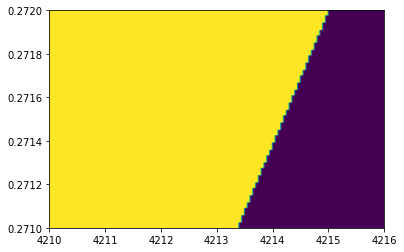

In [636]:
plt.imshow((lum0 >= 0),extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')

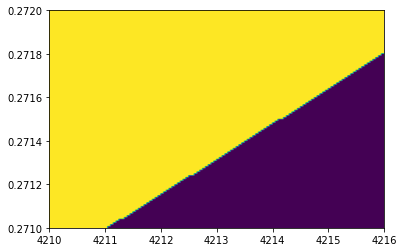

In [637]:
plt.imshow((mass0 >= 0),extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')

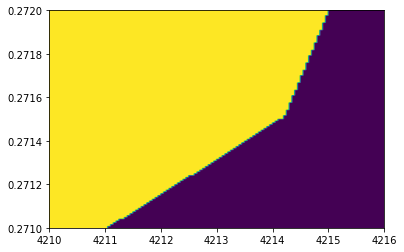

In [638]:
plt.imshow((mass0 >= 0)*(lum0 >= 0),extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')

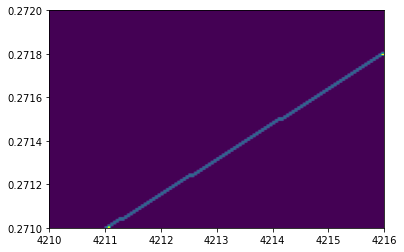

In [639]:
mcross = crossing(mass0)
plt.imshow(mcross,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')

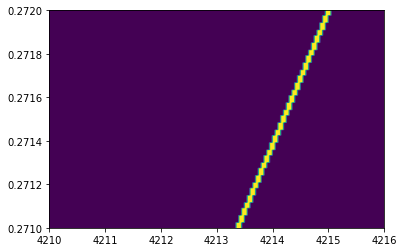

In [640]:
lcross = crossing(lum0)
plt.imshow(lcross,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')

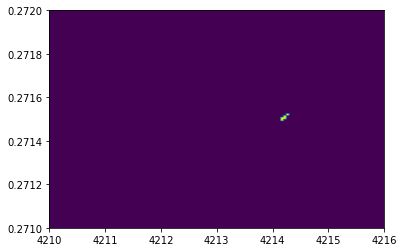

In [641]:
lmcross = mcross & lcross
plt.imshow(lmcross,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')

In [642]:
ind = np.where((lmcross==1) & (mass0>=0) & (lum0>=0))
print(ind)
print('Luminosity = ',luminosity[ind[0]])
print('Temperature = ',temperature[ind[1]])
print('Mean Luminosity = ',np.mean(luminosity[ind[0]]))
print('Mean Temperature = ',np.mean(temperature[ind[1]]))
print(mass0[ind])
print(lum0[ind])

(array([60]), array([83]))
Luminosity =  [0.2715042]
Temperature =  [4214.18487395]
Mean Luminosity =  0.2715042016806723
Mean Temperature =  4214.18487394958
[1.00947702e+26]
[6.60303543e+28]


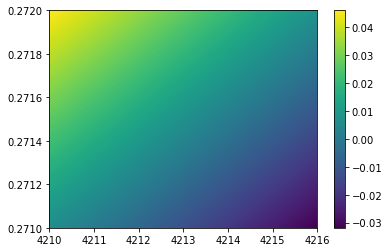

In [643]:
plt.imshow(mass0/(0.01*0.8*Msun),extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
plt.colorbar()

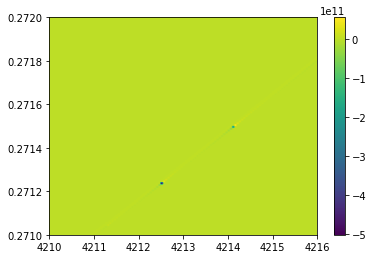

In [644]:
plt.imshow(dtemp0,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
plt.colorbar()

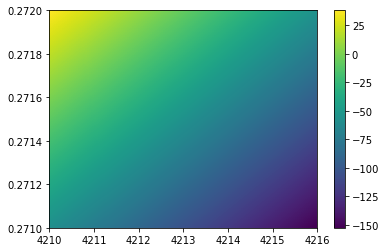

In [645]:
plt.imshow(drho0,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
plt.colorbar()

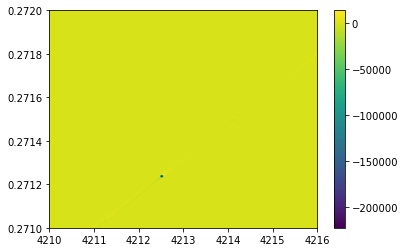

In [646]:
plt.imshow(deps0,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
plt.colorbar()

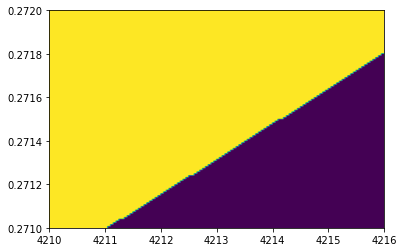

In [647]:
plt.imshow(criteria[:,:,0],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)

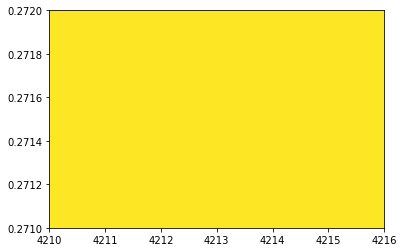

In [648]:
plt.imshow(criteria[:,:,1],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)

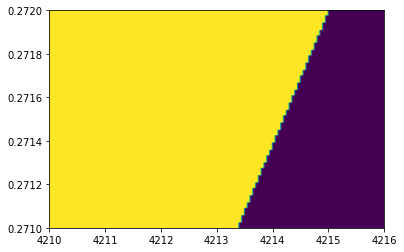

In [649]:
plt.imshow(criteria[:,:,2],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)

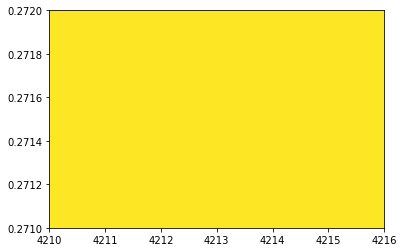

In [650]:
plt.imshow(criteria[:,:,3],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)

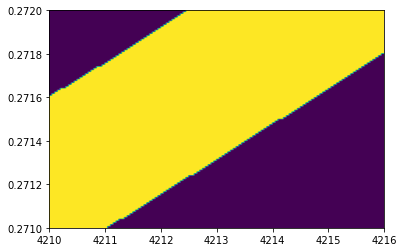

In [651]:
plt.imshow(criteria[:,:,4],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)

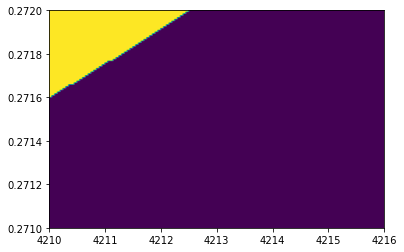

In [652]:
plt.imshow(criteria[:,:,5],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)

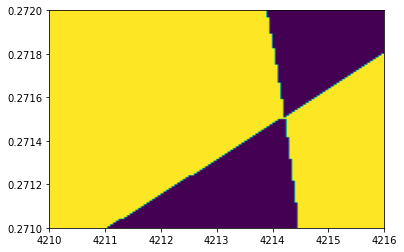

In [653]:
plt.imshow(criteria[:,:,6],extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)

(array([ 72,  73,  74,  75,  76,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119]), array([ 0,  1,  2,  3,  4,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49]))
Luminosity =  [0.27160504 0.27161345 0.27162185 0.27163025 0.27163866 0.27166387
 0.27167227 0.27168067 0.27168908 0.27169748 0.27170588 0.27171429
 0.27172269 0.27173109 0.2717395  0.27177311 0.27178151 0.27178992
 0.27179832 0.27180672 0.27181513 0.27182353 0.27183193 0.27184034
 0.27184874 0.27185714 0.27186555 0.27187395 0.27188235 0.27189076
 0.27189916 0.27190756 0.27191597 0.27192437 0.27193277 0.27194118
 0.27194958 0.27195798 0.27196639 0.27197479 0.27198319 0.2719916
 0.272     ]
Temperature =  [4210.         4210.05042017 4210.10084034 4210.1

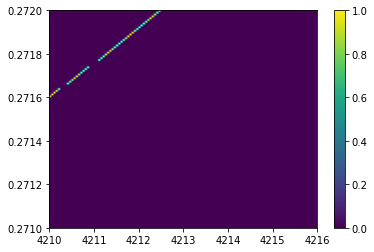

In [661]:
allcriteria = criteria[:,:,0] * criteria[:,:,1] * criteria[:,:,2] * criteria[:,:,3] * criteria[:,:,4] * criteria[:,:,5] * criteria[:,:,6] 
plt.imshow(allcriteria,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto',vmin=0,vmax=1)
plt.colorbar()
ind = np.where(allcriteria==1)
print(ind)
print('Luminosity = ',luminosity[ind[0]])
print('Temperature = ',temperature[ind[1]])
print(mass0[ind])

In [660]:
np.sum(igoof==0)

43

Best index =  (61, 84)
Best Luminosity= 0.27151260504201685
Best Temperature= 4214.235294117647


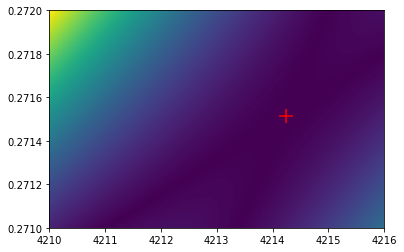

In [655]:
bestind = np.unravel_index(np.argmin(np.abs(mass0)*np.abs(lum0), axis=None), mass0.shape)
bestlum = luminosity[bestind[0]]
bestteff = temperature[bestind[1]]
print('Best index = ',bestind)
print('Best Luminosity=',luminosity[bestind[0]])
print('Best Temperature=',temperature[bestind[1]])
plt.imshow(np.abs(mass0)*np.abs(lum0),extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
plt.scatter(temperature[bestind[1]],luminosity[bestind[0]],c='r',marker='+',s=200)


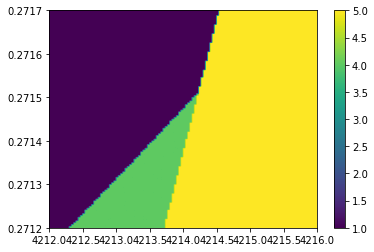

In [546]:
plt.imshow(igoof,extent=[temperature[0],temperature[-1],luminosity[0],luminosity[-1]],
               origin='lower',aspect='auto')
plt.colorbar()

# Run example
mass = 1.0 <br>
luminosity = 0.86071 <br>
teff = 5500.2 <br>
X = 0.70 <br>
Z = 0.008

In [662]:
# 0.27155462,4212.18487  was closer
# 0.27151260,4214.24369
# 0.271512605, 4214.234453
# 0.27151092, 4214.2296
# 0.27151092, 4214.21848739
Igoof,ierr,istop,tab = starmodel(0.8,0.27160504,4210.,0.70,0.008)

CONGRATULATIONS, I THINK YOU FOUND IT!
However, be sure to look at your model carefully.

***** The integration has been completed *****
      The model has been stored in starmodl_py.dat



In [579]:
print('Central M=',tab['M'][-1])
print('Central L=',tab['L'][-1]) 
print(np.max(tab['L']))
print(np.max(tab['M']))
print(tab['M'][-1]/np.max(tab['M']))
print(tab['L'][-1]/np.max(tab['L']))
# Mcore < 0.01*Mstar, but positive
# Lcore < 0.1*Lstar, but positive
# Tcore > Tshell2
# rhocore > rhoshell2
# epsiloncore > epsilonshell2
print(tab['T'][-3:])
print(tab['rho'][-3:])
print(tab['epsilon'][-3:])

Central M= 3.0925897047800313e+29
Central L= 1.579110564805814e+30
1.0406720000000001e+33
1.5912000000000003e+33
0.00019435581352312913
0.001517395072420334
[11564954.84401136 11609856.08398982 18196798.65607819]
[73.90144576 74.45089101 47.69429051]
[6.2111386  6.36659416 5.10611079]


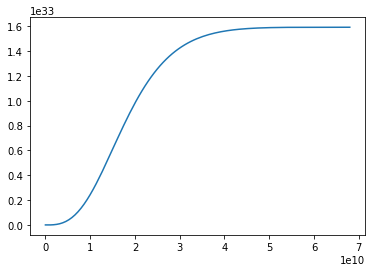

In [539]:
plt.plot(tab['r'],tab['M'])

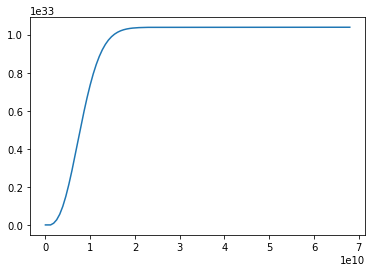

In [540]:
plt.plot(tab['r'],tab['L'])